In [19]:
from pathlib import Path

# specify input and output paths
data_folder = Path(r"C:\Users\Amr\Desktop\New folder\TCGA-02-0003")

t1c_file = data_folder / "t1c.nii.gz"
t1_file = data_folder / "t1.nii.gz"
fla_file = data_folder / "flair.nii.gz"
t2_file = data_folder / "t2.nii.gz"

output_dir = Path("output")
t1c_normalized_skull_output_path = output_dir / "t1c_normalized_skull.nii.gz"
t1c_normalized_bet_output_path = output_dir / "t1c_normalized_bet.nii.gz"
t1c_normalized_defaced_output_path = output_dir / "t1c_normalized_defaced.nii.gz"
t1c_bet_mask = output_dir / "t1c_bet_mask.nii.gz"
t1c_defacing_mask = output_dir / "t1c_defacing_mask.nii.gz"

t1_normalized_bet_output_path = output_dir / "t1_normalized_bet.nii.gz"
fla_normalized_bet_output_path = output_dir / "fla_normalized_bet.nii.gz"
t2_normalized_bet_output_path = output_dir / "t2_normalized_bet.nii.gz"

In [9]:
from pathlib import Path

from brainles_preprocessing.defacing import QuickshearDefacer
from brainles_preprocessing.brain_extraction import HDBetExtractor
from brainles_preprocessing.modality import Modality, CenterModality
from brainles_preprocessing.preprocessor import Preprocessor
from brainles_preprocessing.registration import ANTsRegistrator
from brainles_preprocessing.normalization.percentile_normalizer import (
    PercentileNormalizer,
)


In [17]:
from pathlib import Path
from typing import List, Optional
import matplotlib.pyplot as plt
import nibabel as nib


def visualize_data(files: List[Path], label: str, titles: Optional[List[str]] = None):
    """Visualize the MRI modalities

    Args:
        files (List[Path]): List of paths to the MRI modalities
        label (str): Label for the y-axis on the far left left, i.e. category of the passed images (e.g. input, output)
        titles (Optional[List[str]], optional): Title of images. Defaults to None.
    """
    _, axes = plt.subplots(1, len(files), figsize=(len(files) * 4, 10))

    for i, file in enumerate(files):
        modality_np = nib.load(file).get_fdata().transpose(2, 1, 0)
        axes[i].set_title(titles[i] if titles else file.name)
        axes[i].imshow(modality_np[modality_np.shape[0] // 2, :, :], cmap="gray")
    axes[0].set_ylabel(label)


def visualize_defacing(
    file: Path,
):
    """Visualize the defacing of the MRI modality

    Args:
        file (Path): Path to the MRI modality
    """

    modality_np = nib.load(file).get_fdata().transpose(2, 1, 0)
    plt.figure(figsize=(4, 5))
    plt.title(file.name)
    plt.imshow(modality_np[:, ::-1, 75], cmap="gray", origin="lower")

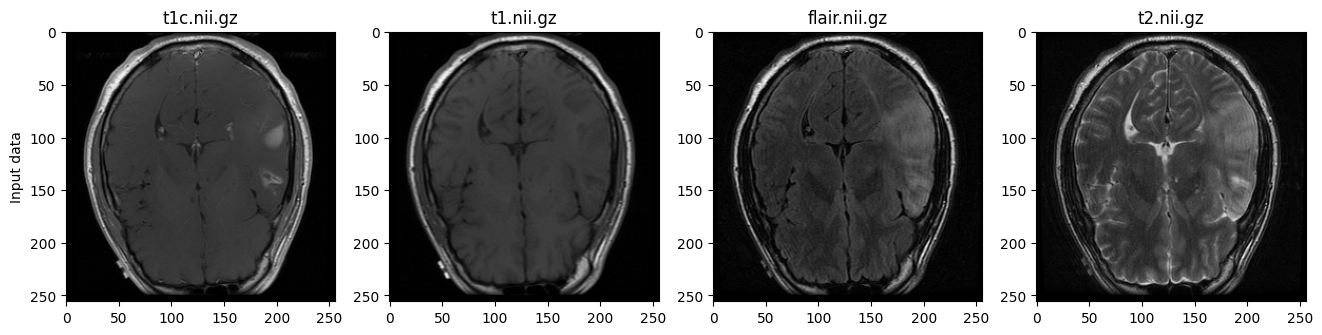

In [20]:
visualize_data(files=[t1c_file, t1_file, fla_file, t2_file], label="Input data")


In [21]:
# normalizer
percentile_normalizer = PercentileNormalizer(
    lower_percentile=0.1,
    upper_percentile=99.9,
    lower_limit=0,
    upper_limit=1,
)
# define modalities


# Define the center modality, i.e. the modality to which all other modalities are co-registered has its own class
# to allow saving saving additional that are only relevant for the center modality (brain extraction (bet) and defacing masks)

center = CenterModality(
    modality_name="t1c",
    input_path=t1c_file,
    normalizer=percentile_normalizer,
    # specify desired outputs, here we want to save the normalized skull, bet and defaced images
    normalized_skull_output_path=t1c_normalized_skull_output_path,
    normalized_bet_output_path=t1c_normalized_bet_output_path,
    normalized_defaced_output_path=t1c_normalized_defaced_output_path,
    # also save the bet and defacing mask
    bet_mask_output_path=t1c_bet_mask,
    defacing_mask_output_path=t1c_defacing_mask,
)


# Define the moving modalities, i.e. the modalities that are co-registered to the center modality.
# They mostly have the same structure as the center modality, but do not have some additional output (brain extraction (bet) and defacing masks)
moving_modalities = [
    Modality(
        modality_name="t1",
        input_path=t1_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=t1_normalized_bet_output_path,
    ),
    Modality(
        modality_name="t2",
        input_path=t2_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=t2_normalized_bet_output_path,
    ),
    Modality(
        modality_name="flair",
        input_path=fla_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=fla_normalized_bet_output_path,
    ),
]
preprocessor = Preprocessor(
    center_modality=center,
    moving_modalities=moving_modalities,
    # Use ANTs for registration, other options are Niftyreg or eReg
    registrator=ANTsRegistrator(),
    # Use HDBet for brain extraction
    brain_extractor=HDBetExtractor(),
    # Use Quickshear for defacing,
    defacer=QuickshearDefacer(),
    # limit cuda devices to the gpu you want to use. CPU computation is also possible but slow
    limit_cuda_visible_devices="0",
)

In [ ]:
preprocessor.run()

[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: ============================ Starting preprocessing ============================
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: Logs are saved to c:\Users\Amr\Desktop\Masters\Project\preprocessing\brainles_preprocessing_2025-01-19_T18-09-00.057159.log
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: Received center modality: t1c and moving modalities: t1, t2, flair
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: --------------------------- Starting Coregistration ----------------------------
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: Coregistering 3 moving modalities to center modality...
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:00+0100: Registering modality t1 (file=co__t1c__t1) to center modality...
[INFO | brainles_preprocessing.preprocessor] 2025-01-19T18:09:02+0100: Registering modality t2 (file

c:\Users\Amr\anaconda3\envs\msc\Lib\site-packages\brainles_hd_bet\run.py:101: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



File: C:\Users\Amr\AppData\Local\Temp\tmpat9r8pk8\atlas-space\atlas__t1c.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0


In [ ]:
from pathlib import Path
from typing import List

# Function to run the pipeline for all subjects in a folder
def process_all_subjects_in_folder(data_folder: Path, output_folder: Path):
    # List all subject directories in the data folder
    subject_dirs = [d for d in data_folder.iterdir() if d.is_dir()]
    
    for subject_dir in subject_dirs:
        print(f"Processing subject: {subject_dir.name}")
        
        # Define file paths for the current subject
        t1c_file = subject_dir / "t1c.nii.gz"
        t1_file = subject_dir / "t1.nii.gz"
        fla_file = subject_dir / "flair.nii.gz"
        t2_file = subject_dir / "t2.nii.gz"
        
        # Output paths
        t1c_normalized_skull_output_path = output_folder / f"{subject_dir.name}_t1c_normalized_skull.nii.gz"
        t1c_normalized_bet_output_path = output_folder / f"{subject_dir.name}_t1c_normalized_bet.nii.gz"
        t1c_normalized_defaced_output_path = output_folder / f"{subject_dir.name}_t1c_normalized_defaced.nii.gz"
        t1c_bet_mask = output_folder / f"{subject_dir.name}_t1c_bet_mask.nii.gz"
        t1c_defacing_mask = output_folder / f"{subject_dir.name}_t1c_defacing_mask.nii.gz"

        t1_normalized_bet_output_path = output_folder / f"{subject_dir.name}_t1_normalized_bet.nii.gz"
        fla_normalized_bet_output_path = output_folder / f"{subject_dir.name}_fla_normalized_bet.nii.gz"
        t2_normalized_bet_output_path = output_folder / f"{subject_dir.name}_t2_normalized_bet.nii.gz"

        # Create a PercentileNormalizer
        percentile_normalizer = PercentileNormalizer(
            lower_percentile=0.1,
            upper_percentile=99.9,
            lower_limit=0,
            upper_limit=1,
        )

        # Define the center modality
        center = CenterModality(
            modality_name="t1c",
            input_path=t1c_file,
            normalizer=percentile_normalizer,
            normalized_skull_output_path=t1c_normalized_skull_output_path,
            normalized_bet_output_path=t1c_normalized_bet_output_path,
            normalized_defaced_output_path=t1c_normalized_defaced_output_path,
            bet_mask_output_path=t1c_bet_mask,
            defacing_mask_output_path=t1c_defacing_mask,
        )

        # Define the moving modalities
        moving_modalities = [
            Modality(
                modality_name="t1",
                input_path=t1_file,
                normalizer=percentile_normalizer,
                normalized_bet_output_path=t1_normalized_bet_output_path,
            ),
            Modality(
                modality_name="t2",
                input_path=t2_file,
                normalizer=percentile_normalizer,
                normalized_bet_output_path=t2_normalized_bet_output_path,
            ),
            Modality(
                modality_name="flair",
                input_path=fla_file,
                normalizer=percentile_normalizer,
                normalized_bet_output_path=fla_normalized_bet_output_path,
            ),
        ]

        # Initialize the Preprocessor
        preprocessor = Preprocessor(
            center_modality=center,
            moving_modalities=moving_modalities,
            registrator=ANTsRegistrator(),
            brain_extractor=HDBetExtractor(),
            defacer=QuickshearDefacer(),
            limit_cuda_visible_devices="0",  # Adjust as per your GPU
        )

        # Run the preprocessor pipeline for the current subject
        preprocessor.run()
        print(f"Finished processing subject: {subject_dir.name}")

# Specify the data folder and output folder paths
data_folder = Path(r"C:\Users\Amr\Desktop\MRI_GBM")  # Folder with all subjects
output_folder = Path("output")  # Folder to save the results

# Ensure the output folder exists
if not output_folder.exists():
    output_folder.mkdir(parents=True)

# Process all subjects in the folder
process_all_subjects_in_folder(data_folder, output_folder)


In [ ]:
data_folder = Path(r"C:\Users\Amr\Desktop\Newfolder")
output_folder = Path(r'output')